#### Directory path setup

In [1]:
import sys, os

filePath = "F:\\TUDelft\\ResearchAssistant\\research\\code\\RK4_SinDy-main"

sys.path.insert(0, filePath)

#### Dependencies

In [2]:
import numpy as np
import torch
from scipy.integrate import solve_ivp
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pysindy as ps
import Dictionary.polynomial_library_torch as pl_torch
from Functions.modules import coeffs_dictionary
from Functions.utils import printing_learned_model

from Functions.models import hopf
from Functions.learning_models import learning_sparse_model_parameter
from IPython.utils.io import Tee
from contextlib import closing
import tikzplotlib

##### Seed

In [3]:
randSeed = 42

torch.manual_seed(randSeed)
np.random.seed(seed=randSeed)

#### Parameters

In [4]:
@dataclass
class parameters:
    bs: int = 2
    num_epochs: int = 1000
    lr: float = 5e-3
    save_model_path: str = './Results/Hopf/'
    weightdecay: float =0.0
    dim_x: int = 2
    timefinal: float = 75.0
    timestep: float = 0.2
    normalize: bool = False
    tol_coeffs: float = 5e-2
    eps: float = 0.001
    tikz_save: bool = False


Params = parameters()

os.makedirs(os.path.dirname(Params.save_model_path), exist_ok=True)

#### Model and looping variables

In [5]:
dynModel = hopf

omega = 1
A = 1

mu_stable = np.array([-0.15, -0.05])
mu_unstable = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55])
Params.NumParams = mu_stable.size + 2 * mu_unstable.size

<h4> Collect training data

In [6]:
t_train = np.arange(0, Params.timefinal, Params.timestep)
ts = np.arange(0, Params.timefinal, Params.timestep)

x = np.zeros((Params.NumParams,len(ts),Params.dim_x))
Ts = np.zeros((Params.NumParams,len(ts),1))
Mu = np.zeros((Params.NumParams,len(ts),1))

eps = Params.eps
ic_idx = 0

for mu in mu_stable:
    x0_train = [2, 0]
    
    sol = solve_ivp(lambda t, x: dynModel(x, mu, omega, A), [ts[0], ts[-1]], x0_train, t_eval=ts)
    x1 = np.transpose(sol.y)
    x[ic_idx] = x1 + eps * np.random.normal(size=x1.shape)
    Ts[ic_idx] = ts.reshape(-1,1)
    Mu[ic_idx] = mu
    ic_idx += 1

for mu in mu_unstable:
    x0_train = [0.01, 0]
    
    sol = solve_ivp(lambda t, x: dynModel(x, mu, omega, A), [ts[0], ts[-1]], x0_train, t_eval=ts)
    x1 = np.transpose(sol.y)
    x[ic_idx] = x1 + eps * np.random.normal(size=x1.shape)
    Ts[ic_idx] = ts.reshape(-1,1)
    Mu[ic_idx] = mu
    ic_idx += 1

    x0_train = [2, 0]
    
    sol = solve_ivp(lambda t, x: dynModel(x, mu, omega, A), [ts[0], ts[-1]], x0_train, t_eval=ts)
    x1 = np.transpose(sol.y)
    x[ic_idx] = x1 + eps * np.random.normal(size=x1.shape)
    Ts[ic_idx] = ts.reshape(-1,1)
    Mu[ic_idx] = mu
    ic_idx += 1

<h4> Plotting training data

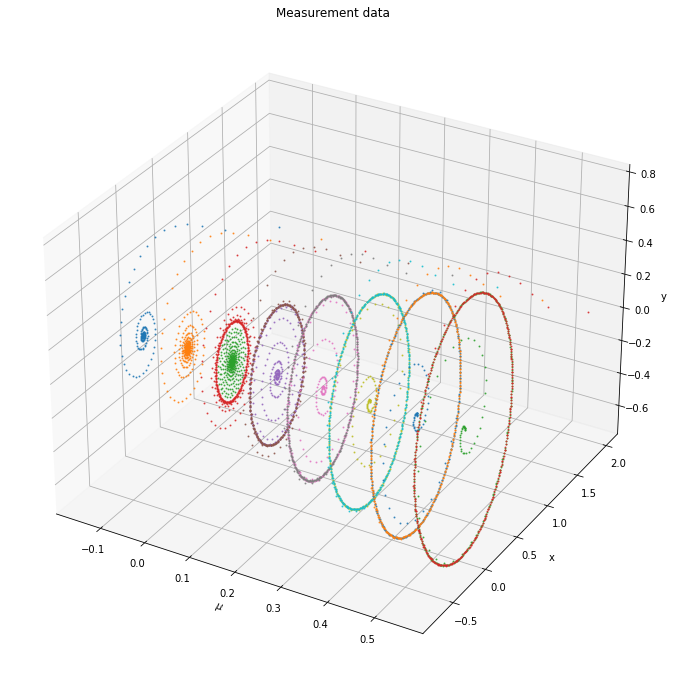

In [8]:
fig = plt.figure(figsize=(20, 12))
plot_kws=dict(alpha=0.75, linewidth=1)

ax = fig.add_subplot(111, projection="3d")
for i in range(Params.NumParams):
    if i > 2 and i % 2 == 0:
        ax.plot(
            Mu[i].reshape(-1,), x[i,:, 0], x[i,:, 1],'o', markersize=1, **plot_kws)
    else:
        ax.plot(Mu[i].reshape(-1,), x[i,:, 0], x[i,:, 1],'o', markersize=1,**plot_kws)

ax.set(title="Measurement data", xlabel="$\mu$", ylabel="x", zlabel="y");

if Params.tikz_save:
    tikzplotlib.save(Params.save_model_path + "Hopf_training.tex")
plt.show()
fig.savefig(Params.save_model_path + "Hopf_training.pdf", bbox_inches = 'tight',pad_inches = 0.01)


<h4> Define dataloaders

In [9]:
train_dset = list(zip(torch.tensor(x).float(),torch.tensor(Ts).float(),torch.tensor(Mu).float()))
train_dl = torch.utils.data.DataLoader(train_dset, batch_size =Params.bs,shuffle=True)
dataloaders = {'train': train_dl}

<h4> Performing assessment for the polynomial order

Performing polynomial order assessment test 


For polynomial order: 0
--------------------------
 [Iter 1/1] [Epoch 1000/1000] [Training loss: 7.66e-02] [Learning rate: 5.00e-03]
For polynomial order: 1
--------------------------
 [Iter 1/1] [Epoch 1000/1000] [Training loss: 6.40e-03] [Learning rate: 5.00e-03]
For polynomial order: 2
--------------------------
 [Iter 1/1] [Epoch 1000/1000] [Training loss: 2.49e-03] [Learning rate: 5.00e-03]
For polynomial order: 3
--------------------------
 [Iter 1/1] [Epoch 1000/1000] [Training loss: 4.27e-05] [Learning rate: 5.00e-03]
For polynomial order: 4
--------------------------
 [Iter 1/1] [Epoch 1000/1000] [Training loss: 5.95e-05] [Learning rate: 5.00e-03]
For polynomial order: 5
--------------------------
 [Iter 1/1] [Epoch 1000/1000] [Training loss: 3.89e-05] [Learning rate: 5.00e-03]

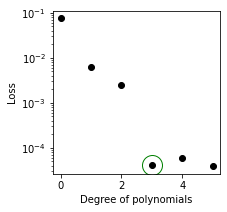

In [10]:
print('='*75 + '\n' + 'Performing polynomial order assessment test \n' + '='*75 + '\n')
Params.num_iter = 1
loss_order = np.zeros((6,Params.num_epochs))


for order in range(6):
    print(f'\nFor polynomial order: {order}\n--------------------------')
    Params.poly_order = order
    funs_dictionary = pl_torch.PolynomialLibrary(degree = Params.poly_order)
    funs_dictionary.fit(np.concatenate((x[0],Mu[0]),axis=1))
    funs_dictionary_size = funs_dictionary.transform(np.concatenate((x[0],Mu[0]),axis=1)).shape[1]
    funs_dictionary_size, funs_dictionary.get_feature_names(input_features = ['x','y','z'])
           
    Coeffs = coeffs_dictionary(funs_dictionary_size,Params.dim_x)
    Coeffs, loss_track = learning_sparse_model_parameter(funs_dictionary, Coeffs, dataloaders, Params,quite = True)
    
    loss_order[order] = loss_track
# Plotting Pareto front
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)
for i in range(6):
    ax.semilogy(i,loss_order[i,-1],'ko')
ax.semilogy(3,loss_order[3,-1],'go', markersize = 20,fillstyle='none')
ax.set(xlabel="Degree of polynomials", ylabel="Loss")

if Params.tikz_save:
    tikzplotlib.save(Params.save_model_path + "Hopf_order.tex")
plt.show()
fig.savefig(Params.save_model_path + "Hopf_order.pdf", bbox_inches = 'tight',pad_inches = 0.1)


<h4>RK4-SINDy for polynomial degree-3

In [11]:
print('='*75 + '\n' + 'Doing fine-tuning for polynomial order-3 \n' + '='*75 + '\n')
Params.num_iter = 3
Params.poly_order = 3
loss_track = np.zeros((Params.num_iter,Params.num_epochs))
funs_dictionary = pl_torch.PolynomialLibrary(degree = Params.poly_order)
funs_dictionary.fit(np.concatenate((x[0],Mu[0]),axis=1))
funs_dictionary_size = funs_dictionary.transform(np.concatenate((x[0],Mu[0]),axis=1)).shape[1]
funs_dictionary_size, funs_dictionary.get_feature_names(input_features = ['x','y','z'])


Coeffs = coeffs_dictionary(funs_dictionary_size,Params.dim_x)
Coeffs, loss_track = learning_sparse_model_parameter(funs_dictionary, Coeffs, dataloaders, Params,quite = True)

Learned_Coeffs = Coeffs.linear.weight.detach().clone().t().numpy()

Doing fine-tuning for polynomial order-3 

 [Iter 3/3] [Epoch 1000/1000] [Training loss: 4.17e-05] [Learning rate: 5.00e-05]

<h3>SINDy

In [12]:
# Generate training data
n_ics = mu_stable.size + 2 * mu_unstable.size
x_train = [np.zeros((t_train.size, 3)) for i in range(n_ics)]
eps = Params.eps
ic_idx = 0

for mu in mu_stable:
    x0_train = [2, 0]
    sol = solve_ivp(lambda t, x: dynModel(x, mu, omega, A), [ts[0], ts[-1]], x0_train, t_eval=ts)
    x = np.transpose(sol.y)
    x_train[ic_idx][:, 0:2] = x + eps * np.random.normal(size=x.shape)
    x_train[ic_idx][:, 2] = mu
    ic_idx += 1

for mu in mu_unstable:
    x0_train = [0.01, 0]
    sol = solve_ivp(lambda t, x: dynModel(x, mu, omega, A), [ts[0], ts[-1]], x0_train, t_eval=ts)
    x = np.transpose(sol.y)
    x_train[ic_idx][:, 0:2] = x + eps * np.random.normal(size=x.shape)
    x_train[ic_idx][:, 2] = mu
    ic_idx += 1

    x0_train = [2, 0]
    sol = solve_ivp(lambda t, x: dynModel(x, mu, omega, A), [ts[0], ts[-1]], x0_train, t_eval=ts)
    x = np.transpose(sol.y)
    x_train[ic_idx][:, 0:2] = x + eps * np.random.normal(size=x.shape)
    x_train[ic_idx][:, 2] = mu
    ic_idx += 1
    
optimizer = ps.STLSQ(threshold=0.5)
library = ps.PolynomialLibrary(degree=3)
model = ps.SINDy(optimizer=optimizer, feature_library=library, feature_names=['x','y','mu'])
model.fit(x_train, t=Params.timestep, multiple_trajectories=True, quiet=True)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3),
      feature_names=['x', 'y', 'mu'], optimizer=STLSQ(threshold=0.5))

<h4> Printing of the identified sparse models

In [13]:
with closing(Tee(Params.save_model_path + "Hopf_DiscoveredModels.log", "a+", channel="stdout")) as outputstream:
    # printing of the learned sparse models in a file
    print('\n')
    print('='*50)
    print('RK4 Inspired Methods Sparse Identification')
    printing_learned_model(Learned_Coeffs,funs_dictionary.get_feature_names())
    print('='*50)
    print('Sindy Approach')
    model.print()
    print('='*50)



RK4 Inspired Methods Sparse Identification
dx0'= -1.001 x1 + 1.001 x0 x2 + -0.996 x0^3 + -0.996 x0 x1^2 
dx1'= 1.001 x0 + 1.011 x1 x2 + -1.006 x0^2 x1 + -1.004 x1^3 
Sindy Approach
(x)' = -0.895 y + 0.649 x mu + 0.588 y mu + -0.660 x^3 + -1.259 x^2 y + -0.607 x y^2 + -1.049 y^3 + 0.630 y mu^2
(y)' = 0.984 x + 0.902 y mu + -0.880 x^2 y + -0.902 y^3
(mu)' = 0.000


<h4>Simulate identified model using RK4-SINDy and grouth truth for new parameters

In [14]:
f1 = lambda z: (funs_dictionary.transform(np.expand_dims(z, axis=0))@Learned_Coeffs).reshape(-1,)
learnt_deri = lambda z,t,p: np.array(f1(np.concatenate((z,np.array([p])),axis=0)))
    

mu_stable = np.array([-0.3, -0.2, -0.1])
mu_unstable = np.array([0.1, 0.3,  0.5,0.7,0.9,1.1])

Params.NumParams = mu_stable.size + 2 * mu_unstable.size

Params.timestep = 0.02 # made a finer time steps for testing
ts = np.arange(0, Params.timefinal, Params.timestep)

x = np.zeros((Params.NumParams,len(ts),Params.dim_x))
x_learnt = np.zeros((Params.NumParams,len(ts),Params.dim_x))

Ts = np.zeros((Params.NumParams,len(ts),1))
Mu = np.zeros((Params.NumParams,len(ts),1))

ic_idx = 0

for mu in mu_stable:
    x0_train = np.array([2, 0])
    
    sol = solve_ivp(lambda t, x: dynModel(x, mu, omega, A), [ts[0], ts[-1]], x0_train, t_eval=ts)
    x1 = np.transpose(sol.y)
    
    sol_learnt = solve_ivp(lambda t, x: learnt_deri(x, t,mu), 
                [ts[0], ts[-1]], x0_train, t_eval=ts)
    x_learnt[ic_idx] = np.transpose(sol_learnt.y)
    
    x[ic_idx] = x1
    Ts[ic_idx] = ts.reshape(-1,1)
    Mu[ic_idx] = mu
    ic_idx += 1

for mu in mu_unstable:
    x0_train = np.array([0.01, 0])
    
    sol = solve_ivp(lambda t, x: dynModel(x, mu, omega, A), [ts[0], ts[-1]], x0_train, t_eval=ts)
    x1 = np.transpose(sol.y)
    
    sol_learnt = solve_ivp(lambda t, x: learnt_deri(x, t,mu), 
                [ts[0], ts[-1]], x0_train, t_eval=ts)
    x_learnt[ic_idx] = np.transpose(sol_learnt.y)
    
    x[ic_idx] = x1 
    Ts[ic_idx] = ts.reshape(-1,1)
    Mu[ic_idx] = mu
    ic_idx += 1

    x0_train = np.array([2, 0])
    
    sol = solve_ivp(lambda t, x: dynModel(x, mu, omega, A), [ts[0], ts[-1]], x0_train, t_eval=ts)
    x1 = np.transpose(sol.y)
    
    sol_learnt = solve_ivp(lambda t, x: learnt_deri(x, t,mu), 
                [ts[0], ts[-1]], x0_train, t_eval=ts)
    x_learnt[ic_idx] = np.transpose(sol_learnt.y)
    
    
    x[ic_idx] = x1
    Ts[ic_idx] = ts.reshape(-1,1)
    Mu[ic_idx] = mu
    ic_idx += 1

<h3> Visualization

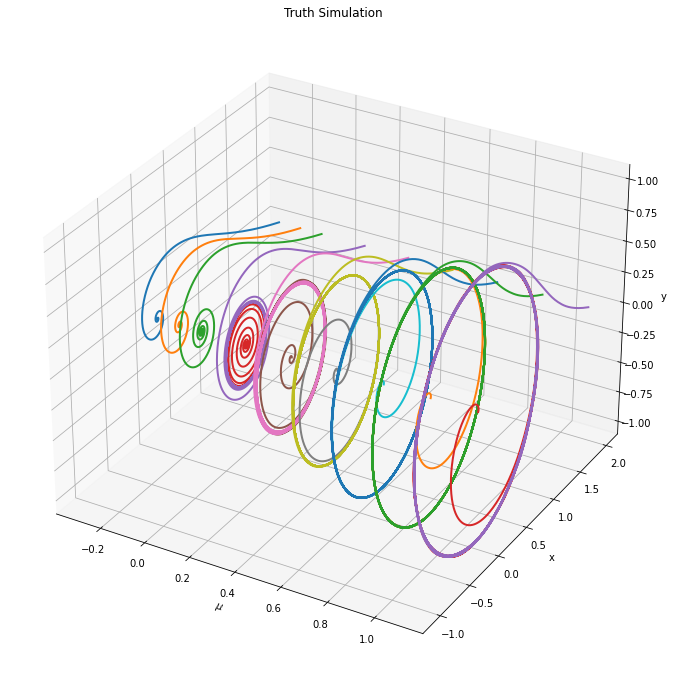

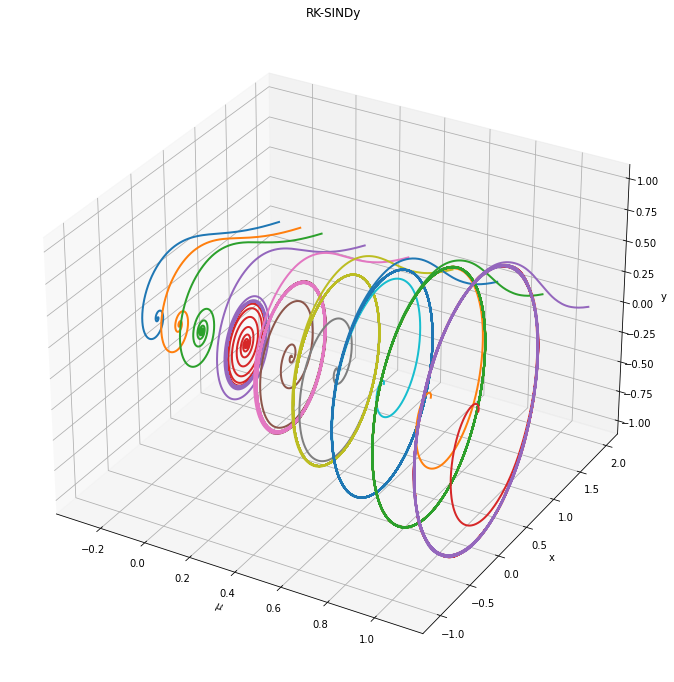

In [17]:
fig = plt.figure(figsize=(20, 12))
plot_kws=dict(alpha=1, linewidth=2)

ax = fig.add_subplot(111, projection="3d")
for i in range(Params.NumParams):
    if i > 2 and i % 2 == 0:
        ax.plot(
            Mu[i].reshape(-1,), x[i,:, 0], x[i,:, 1], **plot_kws)
    else:
        ax.plot(Mu[i].reshape(-1,), x[i,:, 0], x[i,:, 1], **plot_kws)

ax.set(title="Truth Simulation", xlabel="$\mu$", ylabel="x", zlabel="y");

if Params.tikz_save:
    tikzplotlib.save(Params.save_model_path + "Hopf_test_groundtruth.tex")
plt.show()
fig.savefig(Params.save_model_path + "Hopf_test_groundtruth.pdf", bbox_inches = 'tight',pad_inches = 0.01)


fig = plt.figure(figsize=(20, 12))

ax = fig.add_subplot(111, projection="3d")
for i in range(Params.NumParams):
    if i > 2 and i % 2 == 0:
        ax.plot(
            Mu[i].reshape(-1,), x_learnt[i,:, 0], x_learnt[i,:, 1], **plot_kws)
    else:
        ax.plot(Mu[i].reshape(-1,), x_learnt[i,:, 0], x_learnt[i,:, 1], **plot_kws)

ax.set(title="RK-SINDy", xlabel="$\mu$", ylabel="x", zlabel="y");

if Params.tikz_save:
    tikzplotlib.save(Params.save_model_path + "Hopf_test_learnt.tex")
plt.show()
fig.savefig(Params.save_model_path + "Hopf_test_learnt.pdf", bbox_inches = 'tight',pad_inches = 0.01)